# Periodicity Analysis with CuPy and RAPIDS

## Authors:
   Gorkem Batmaz (Nvidia)

## Introduction

Periodicity is a crucial concept in understanding time-series data in various fields. Periodicity detection discovers recurring patterns at specific intervals.

Time series data is often noisy and requires transformation into a different domain to identify the fundamental frequencies. 

Knowing the periodicity of time-series data is useful for supply chain management, anomaly detection in many industries, including retail and cyber.

In this blog post, we show how to find meaningful frequencies in time-series data using RAPIDS and CuPy. 
The signal we created for this task is the number of logs generated in a typical data center. 

Some malware infections produce periodic activities, e.g. exfiltrating data or communicating with a command and control (C2) server. However, most networks include a substantial amount of non-malicious periodic activity such as backups, software updates. It is challenging to identify malicious activities considering the huge volume of logs generated in data centres. Once all significant frequencies are determined, white/greylisting of activities would become straight forward. 
This work can be repurposed to detect beaconing, denoising of the other signals generated from logs, monitoring of anomalous behaviour in data center logs. 

At first glance, the plot below does not indicate any periodicity.

In [27]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as pyplot
import s3fs
from os import path

In [28]:
if not path.exists("./array.npy"):
    fs = s3fs.S3FileSystem(anon=True)
    fs.get("rapidsai-data/cyber/clx/array.npy", "./array.npy")

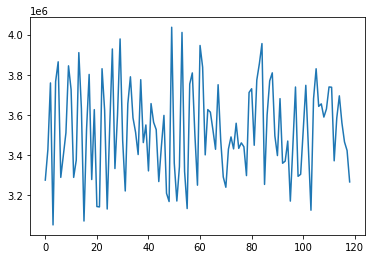

In [29]:
y=cp.load("array.npy")
pyplot.plot(cp.asnumpy(y))

## Switching to Frequency Domain

One way to analyse a time domain signal is to move it into the frequency domain. Moving to the frequency domain can be done with Discrete Fourier Transform.

The Discrete Fourier Transform $ X[k] $ of $ x[n] $ is the discrete-time signal is  

$ X[k]=\sum_{k=0}^{N−1} x[n].e^{−J.2pi.kn/N} $

where $ x[n] $ is a discrete-time signal with Period N.

The Inverse Discrete Fourier transform is

$ x[n]=(1/N)\sum_{k=0}^{N−1} X[k].e^{J.2pi.kn/N} $



Before we start this operation we will standardize the signal

In [30]:
y_standard= (y - cp.mean(y))/cp.std(y)

And take the fourier transform of the signal using CuPy

In [42]:
FFT_data = cp.fft.fft(y_standard)

We are interested in finding frequencies that have high energy, these can be best identified on a periodogram.

Our original signal is real so following the fourier transform the graph is symmetrical hence we will use half of it and plot the periodogram

In [32]:
FFT_data = FFT_data[:int((len(y+1)/2))]

In [33]:
prdg = (1/len(y)) * ((np.absolute(FFT_data))**2)

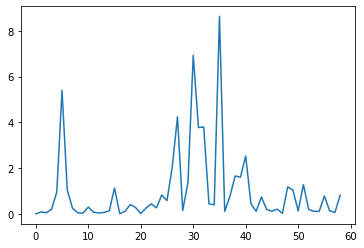

In [34]:
pyplot.plot(cp.asnumpy(prdg))

We will select the important frequencies by eliminating the outliers according to an exponential distribution.


The quantile function for Exponential is derived by finding the value of $Q$ for which $ {\displaystyle 1-e^{-\lambda Q}=p}: $

$ {\displaystyle Q(p;\lambda )={\frac {-\ln(1-p)}{\lambda }},\!} $ where $ 1/{\lambda} $ is the mean and $ Q $ will be our threshold power.

We chose confidence ratio of 99.9% hence $ p $ will be used as 0.001

In [35]:
prdg[prdg < (cp.mean(prdg)*(-1)* (cp.log(0.001)))]=0

Now we have selected the important frequencies

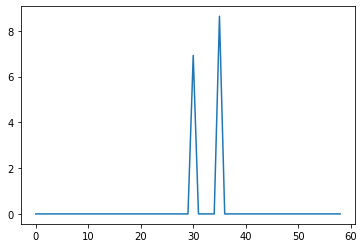

In [36]:
pyplot.plot(cp.asnumpy(prdg))

## Reconstructing the signal in the time domain

To asses the periodicities found from the previous step we can use iFFT on the periodogram to find the autocorrelation function because our signal is real valued.

In [43]:
acf=cp.abs(cp.fft.ifft(prdg))

In [38]:
intervals=cp.linspace(0,len(y),int(len(y)/2))#we had used half of the data in the frequency domain, re-adjusting the x-axis here

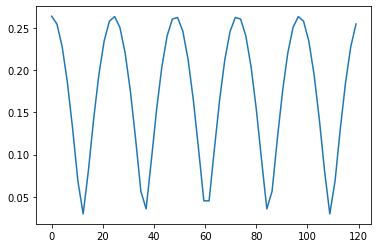

In [39]:
pyplot.plot(cp.asnumpy(intervals),cp.asnumpy(acf))

The peak values at the intervals on the X axis indicate the most significant periods.

References: 
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.75.2564&rep=rep1&type=pdf



